In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))

# Número
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(number_region, cv2.COLOR_BGR2RGB))
plt.title("Número (Crop)")
plt.axis("off")

# Palo
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(suit_region, cv2.COLOR_BGR2RGB))
plt.title("Palo (Crop)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 42, 89)
    kernel = np.ones((2, 2))
    dilated = cv2.dilate(canny, kernel=kernel, iterations=2)
    return dilated

def sort_corners(pts):
    pts = np.array(pts, dtype="float32")
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    tl_index = np.argmin(s)
    br_index = np.argmax(s)
    tr_index = np.argmin(diff)
    bl_index = np.argmax(diff)

    # Asegurar que todos los índices sean distintos
    used = {tl_index, br_index, tr_index, bl_index}
    if len(used) < 4:
        # Si hay repetidos, hacer una asignación más segura
        # Ordenar por Y (de arriba a abajo), luego X
        sorted_pts = sorted(pts, key=lambda p: (p[1], p[0]))
        top_two = sorted(sorted_pts[:2], key=lambda p: p[0])  # izq, der
        bottom_two = sorted(sorted_pts[2:], key=lambda p: p[0])  # izq, der
        rect[0], rect[1] = top_two
        rect[3], rect[2] = bottom_two
    else:
        rect[0] = pts[tl_index]
        rect[2] = pts[br_index]
        rect[1] = pts[tr_index]
        rect[3] = pts[bl_index]

    return rect
"""
def sort_corners(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect
"""
def warp_card(image, contour):
    contour = contour.reshape(4, 2)
    ordered = sort_corners(contour)
    (tl, tr, br, bl) = ordered
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxWidth = int(max(widthA, widthB))
    maxHeight = int(max(heightA, heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")
    M = cv2.getPerspectiveTransform(ordered, dst)
    warp = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warp

"""
def find_card_contours(edges):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    proper = sorted(contours, key=cv2.contourArea, reverse=True)
    card_contours = []

    for cnt in proper:
        area = cv2.contourArea(cnt)
        if area < 3000:
            continue

        perimeter = cv2.arcLength(cnt, closed=True)
        approx = cv2.approxPolyDP(cnt, 0.01 * perimeter, closed=True)  # Más permisivo

        if len(approx) == 4:
            card_contours.append(approx)
        else:
            # 🩹 Fallback con minAreaRect
            rect = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            card_contours.append(box.reshape(-1, 1, 2))

    return card_contours
"""
def find_card_contours(edges):
    # Usamos RETR_TREE para tener jerarquía y descartar contornos internos
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    card_contours = []

    if hierarchy is None:
        return card_contours

    hierarchy = hierarchy[0]
    
    for i, cnt in enumerate(contours):
        # Solo consideramos contornos sin padre (externos)
        if hierarchy[i][3] != -1:
            continue

        area = cv2.contourArea(cnt)
        if area < 3000:
            continue

        # Suavizamos la forma con convex hull
        hull = cv2.convexHull(cnt)
        perimeter = cv2.arcLength(hull, closed=True)
        approx = cv2.approxPolyDP(hull, 0.015 * perimeter, closed=True)

        if len(approx) == 4:
            card_contours.append(approx)
        else:
            # Si el hull+approx aún falla, usar minAreaRect como fallback
            rect = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            card_contours.append(box.reshape(-1, 1, 2))

    return card_contours

def extract_number_suit_region(card_img, debug=False):
    h, w = card_img.shape[:2]

    # 🔍 Recorte desde la esquina superior izquierda
    roi = card_img[0:int(h * 0.25), 0:int(w * 0.18)]  # Ajustable si hace falta más ancho o alto
    
    if debug:
        plt.figure(figsize=(4, 4))
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title("Crop Esquina Superior Izquierda (ROI)")
        plt.axis("off")
        plt.show()
    
    # 🔎 Detectar contornos
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    bin_roi = binarize_region(gray_roi, block_size=30, C=2, blur_ksize=5, use_clahe=True)
    bin_roi = morphological_smoothing(bin_roi)
    # _, bin_roi = cv2.threshold(gray_roi, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(bin_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])  # orden vertical

    ranksuit = []
    _rank = None

    for i, cnt in enumerate(contours):
        x, y, w_cnt, h_cnt = cv2.boundingRect(cnt)
        x2, y2 = x + w_cnt, y + h_cnt
        crop = roi[y:y2, x:x2]

        if i == 0:  # Rank (número)
            crop = cv2.resize(crop, (70, 125), interpolation=cv2.INTER_AREA)
            _rank = crop
        else:  # Suit (palo)
            crop = cv2.resize(crop, (70, 100), interpolation=cv2.INTER_AREA)

            if debug and _rank is not None:
                r_vis = cv2.resize(_rank, (70, 100))
                s_vis = cv2.resize(crop, (70, 100))
                joined = np.concatenate((r_vis, s_vis), axis=1)
                joined = cv2.resize(joined, (250, 200))
                cv2.imshow("Debug Crop", joined)
                cv2.waitKey(0)
                cv2.destroyAllWindows()

        ranksuit.append(crop)

    if len(ranksuit) != 2:
        return None, None

    return ranksuit[0], ranksuit[1]


def resize_for_template(img, template_shape):
    return cv2.resize(img, (template_shape[1], template_shape[0]), interpolation=cv2.INTER_AREA)

def normalize_for_template(img):
    blur = cv2.GaussianBlur(img, (3, 3), 0)
    norm = cv2.normalize(blur.astype('float32'), None, 0, 255, cv2.NORM_MINMAX)
    return norm.astype('uint8')

"""
def binarize_region(region):
    gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY) if len(region.shape) == 3 else region
    blur = cv2.GaussianBlur(gray, (7, 7), 0)  # Suavizar ruido
    binary = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=11, C=4
    )
    return binary
"""

def binarize_region(region, block_size=15, C=2, blur_ksize=5, use_clahe=True):
    # Asegura que el block_size y blur_ksize sean impares
    block_size = block_size if block_size % 2 == 1 else block_size + 1
    blur_ksize = blur_ksize if blur_ksize % 2 == 1 else blur_ksize + 1

    # Conversión a escala de grises si es necesario
    gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY) if len(region.shape) == 3 else region

    # Mejora de contraste local con CLAHE (opcional pero muy efectivo)
    if use_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)

    # Suavizado con Gaussian Blur (reduce ruido antes del umbral)
    blur = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)

    # Binarización adaptativa con inversión
    binary = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        block_size, C
    )

    return binary

def binarize_template(template):
    gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY) if len(template.shape) == 3 else template
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)  # SIN _INV
    return binary

    return binary

def correct_card_orientation(card_img, debug=False):
    h, w = card_img.shape[:2]
    roi_h, roi_w = int(h * 0.3), int(w * 0.1)

    for i in range(4):
        roi = card_img[0:roi_h, 0:roi_w]
        
        if debug:
            plt.figure(figsize=(4, 4))
            plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
            plt.title("ROI")
            plt.axis("off")
            plt.show()
            
        if roi is None or roi.size == 0:
            print("⚠️ ROI vacío. No se puede convertir a escala de grises.")
            return None  # o manejarlo como prefieras
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        #blur = cv2.GaussianBlur(gray, (5, 5), 0)
        bin_roi = binarize_region(gray, block_size=15, C=2, blur_ksize=5, use_clahe=True)
        bin_roi = morphological_smoothing(bin_roi)
        
        """bin_roi = cv2.adaptiveThreshold(
            blur, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            blockSize=11, C=3
        )
        """
        if debug:
            plt.figure(figsize=(4, 4))
            plt.imshow(cv2.cvtColor(bin_roi, cv2.COLOR_BGR2RGB))
            plt.title("ROI")
            plt.axis("off")
            plt.show()
        contours, _ = cv2.findContours(bin_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filtrar contornos pequeños (posibles número y palo)
        filtered = []
        for cnt in contours:
            x, y, wc, hc = cv2.boundingRect(cnt)
            area = wc * hc
            ratio = wc / float(hc) if hc != 0 else 0
            if (300 < area < 15000) and (0.3 < ratio < 1.5):  # Rango para número o símbolo, ajustar si necesario                
                filtered.append((x, y, wc, hc))

        # Ordenar por coordenada Y
        filtered = sorted(filtered, key=lambda b: b[1])
    
        if debug:
            # Copia para dibujar
            contour_img = roi.copy()
            for x, y, wc, hc in filtered:
                cv2.rectangle(contour_img, (x, y), (x + wc, y + hc), (0, 255, 0), 1)
            plt.figure(figsize=(5, 5))
            plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Contornos detectados - Rotación {i*90}°")
            plt.axis("off")
            plt.show()
    
        if len(filtered) >= 1:
            #print("i:", i*90)
            return card_img  

        # ❌ No parece la orientación correcta, rotamos
        card_img = cv2.rotate(card_img, cv2.ROTATE_90_CLOCKWISE)
        #print("i:", i*90, " | filtered:", filtered)
    return card_img

"""


def correct_card_orientation(card_img, debug=False):
    h, w = card_img.shape[:2]
    roi_h, roi_w = int(h * 0.25), int(w * 0.12)  

    for i in range(4):
        roi = card_img[0:roi_h, 0:roi_w]

        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)

        roi_bin = cv2.adaptiveThreshold(
            blur, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            blockSize=11, C=3
        )

        if debug:
            plt.imshow(roi_bin, cmap="gray")
            plt.title(f"ROI Binarizado - Rot {i*90}°")
            plt.axis("off")
            plt.show()

        if contains_valid_symbol(roi_bin, debug=debug):
            if debug:
                print(f"✅ Contenido válido en rotación {i*90}°")
            return card_img

        # Rotar 90 grados para siguiente intento
        card_img = cv2.rotate(card_img, cv2.ROTATE_90_CLOCKWISE)

    if debug:
        print("⚠️ No se detectó orientación clara tras 4 rotaciones.")
    return card_img
"""

def region_has_rank_or_suit(roi, std_thresh=15, dark_thresh=80, min_dark_pixels=250, debug=False):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    std = np.std(gray)
    dark_pixels = np.sum(gray < dark_thresh)

    if debug:
        print(f"STD: {std:.2f}, Dark Pixels: {dark_pixels}")

    return std > std_thresh and dark_pixels > min_dark_pixels


def morphological_smoothing(binary_img, kernel_size_open=(3, 3), kernel_size_close=(5, 5)):
    kernel_open = np.ones(kernel_size_open, np.uint8)
    kernel_close = np.ones(kernel_size_close, np.uint8)

    # 1. Tapar huecos negros en zonas blancas
    closed = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel_close)

    # 2. Quitar puntitos blancos sueltos
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_open)

    return opened

def match_template(region, templates, debug=False):
    binary = binarize_region(region)
    binary = morphological_smoothing(binary)
    
    best_name, best_score = "Desconocido", -1

    for name, template_list in templates.items():
        for template in template_list:
            if template is None:
                continue

            templ_bin = binarize_template(template)
            # templ_bin = normalize_for_template(templ_bin)

            resized = cv2.resize(binary, (templ_bin.shape[1], templ_bin.shape[0]), interpolation=cv2.INTER_AREA)

            if debug:
                # Mostrar REGION (izquierda)
                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(binary, cmap='gray')
                plt.title("Recorte de la carta")
                plt.axis("off")

                # Mostrar TEMPLATE (derecha)
                plt.subplot(1, 2, 2)
                plt.imshow(templ_bin, cmap='gray')  # ya es binarizada
                plt.title(f"Template: {name}")
                plt.axis("off")

                plt.tight_layout()
                plt.show()


            result = cv2.matchTemplate(resized, templ_bin, cv2.TM_CCOEFF_NORMED)
            _, max_val, _, _ = cv2.minMaxLoc(result)
            if debug:
                print(f"{name}: score = {max_val:.4f}")

            if max_val > best_score:
                best_name, best_score = name, max_val

    return best_name

def load_templates():
    numbers = ['Ace','Two','Three','Four','Five','Six','Seven','Eight','Nine','Ten','Jack','Queen','King']
    suits = ['Clubs','Diamonds','Hearts','Spades']

    number_templates = {}
    suit_templates = {}

    for n in numbers:
        pattern = f'Fotos/Plantillas/{n}*.jpg'
        matches = glob.glob(pattern)
        number_templates[n] = [cv2.imread(m, 0) for m in matches if cv2.imread(m, 0) is not None]

    for s in suits:
        pattern = f'Fotos/Plantillas/{s}*.jpg'
        matches = glob.glob(pattern)
        suit_templates[s] = [cv2.imread(m, 0) for m in matches if cv2.imread(m, 0) is not None]

    return number_templates, suit_templates
"""
def load_templates():
    numbers = ['Ace','Two','Three','Four','Five','Six','Seven','Eight','Nine','Ten','Jack','Queen','King']
    suits = ['Clubs','Diamonds','Hearts','Spades']
    number_templates = {n: cv2.imread(f'Fotos/Plantillas/{n}.jpg', 0) for n in numbers}
    suit_templates = {s: cv2.imread(f'Fotos/Plantillas/{s}.jpg', 0) for s in suits}
    return number_templates, suit_templates
"""
def is_valid_card_proportion(warped_img, jump_ratio=0.7, debug=False):
    h, w = warped_img.shape[:2]
    ratio = h / w if w != 0 else 0

    res = (1 - jump_ratio <= ratio) and (ratio <= 1 + jump_ratio)
    
    if debug:
        print(f"[DEBUG] Dimensiones carta: {w}x{h} | Ratio: {ratio:.2f} | {1-jump_ratio } <= {ratio:.2f} <= {1 + jump_ratio}\n\tResultado:{res}")

    return res

def main(path, debug=False):
    # === MAIN EXECUTION ===
    image = cv2.imread(path)
    print("Detectando edges")
    edges = preprocess_image(image)
    if debug:
        plt.figure(figsize=(8, 6))
        plt.imshow(edges, cmap='gray')
        plt.title("Imagen Binarizada para Contornos")
        plt.axis('off')
        plt.show()
    print("Buscando los contornos de cartas")
    card_contours = find_card_contours(edges)

    # Visualizar contornos
    if debug:
        drawn = image.copy()
        cv2.drawContours(drawn, card_contours, -1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
        plt.title("Cartas Detectadas")
        plt.show()

        drawn = np.zeros_like(image)

        # ✅ Dibujar contornos detectados en verde
        cv2.drawContours(drawn, card_contours, -1, (0, 255, 0), 2)

        # 🎨 Mostrar
        plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
        plt.title("Cartas Detectadas (Sobre Fondo Negro)")
        plt.axis("off")
        plt.show()

    print("Analizando las cartas")

    number_templates, suit_templates = load_templates()

    for contour in card_contours:
        
        warped = warp_card(image, contour)
        if warped is None:
            print("Obtención de las esquinas fallido")
            continue
        if debug:
            plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
            plt.title("Carta warped")
            plt.show()
            
        warped = correct_card_orientation(warped, debug)
        if warped is None:
            print("Orientar la carta fallido")
            continue
            
        if debug:
            plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
            plt.title("Transformación de la carta")
            plt.show()
            
        # 📐 Verificamos proporción tras warping
        if not is_valid_card_proportion(warped, debug=debug):
            print("⚠️ Proporción de la carta fuera de rango. Saltando...")
            continue

        number_region, suit_region = extract_number_suit_region(warped)

        if number_region is not None and suit_region is not None:
            
            if debug:
                # Mostrar regiones extraídas
                plt.subplot(1,2,1)
                plt.imshow(cv2.cvtColor(number_region, cv2.COLOR_BGR2RGB))
                plt.title("Número")
                plt.subplot(1,2,2)
                plt.imshow(cv2.cvtColor(suit_region, cv2.COLOR_BGR2RGB))
                plt.title("Palo")
                plt.show()

            number = match_template(number_region, number_templates, debug=debug)
            suit = match_template(suit_region, suit_templates, debug=debug)

            print(f"🃏 Card detected: {number} of {suit}")
            return number, suit
        else:
            continue
    print("⚠️ No se pudieron extraer las regiones del número y palo.")
    return None, None


Detectando edges


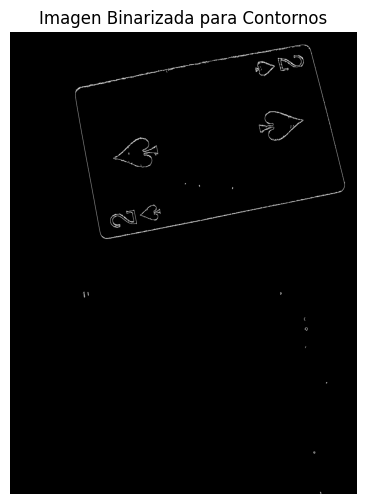

Buscando los contornos de cartas


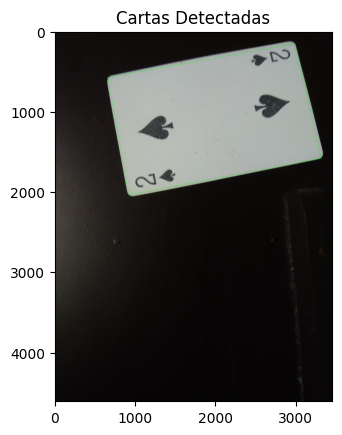

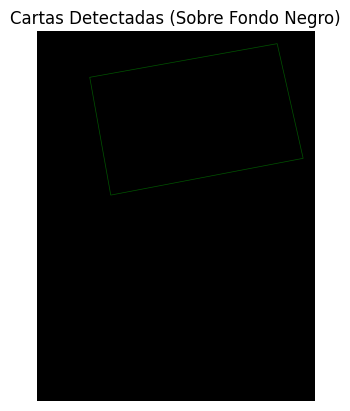

Analizando las cartas


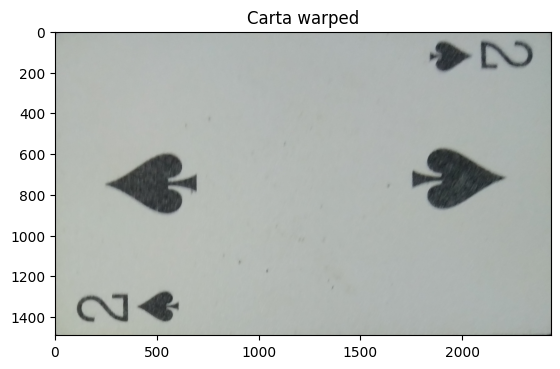

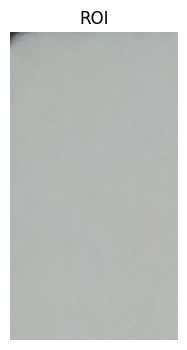

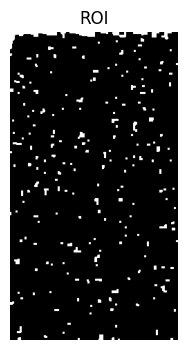

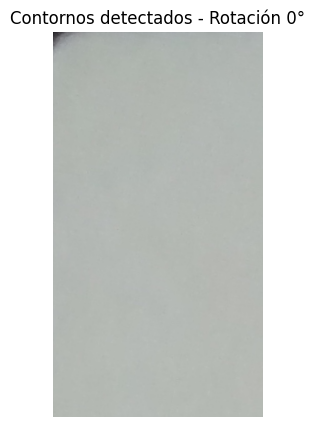

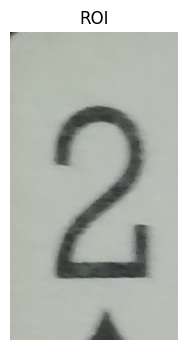

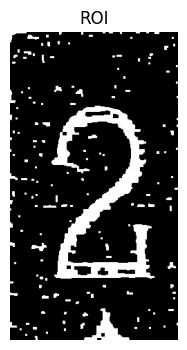

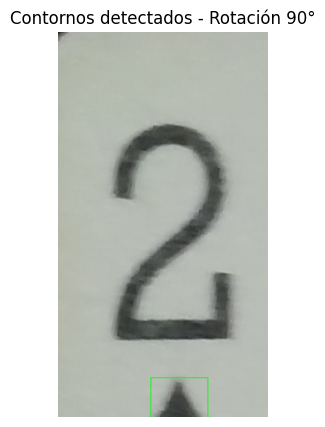

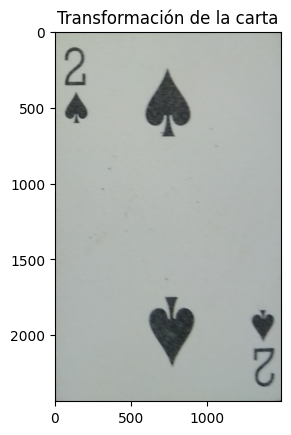

[DEBUG] Dimensiones carta: 1490x2435 | Ratio: 1.63 | 0.30000000000000004 <= 1.63 <= 1.7
	Resultado:True


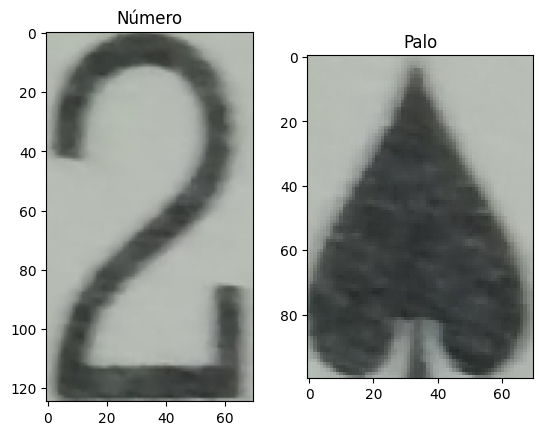

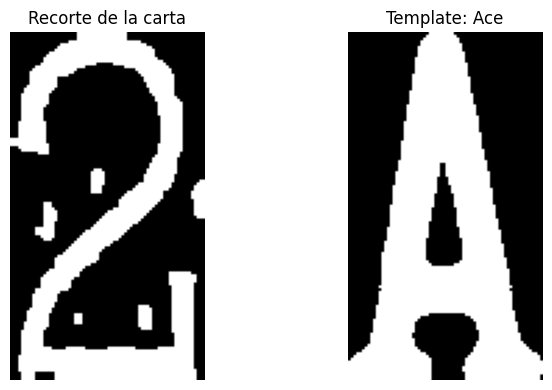

Ace: score = -0.0031


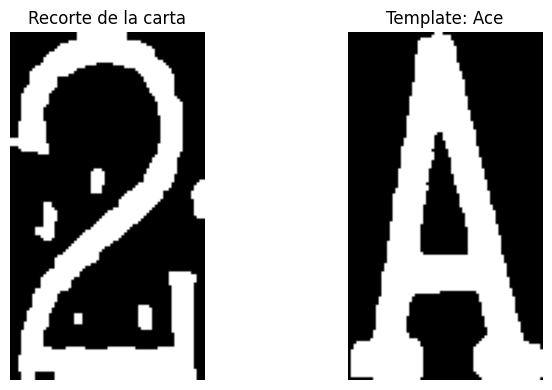

Ace: score = 0.0042


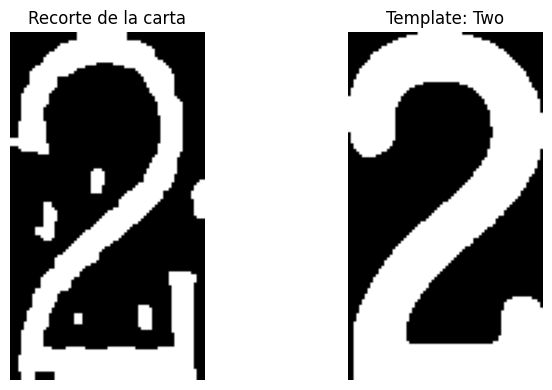

Two: score = 0.5566


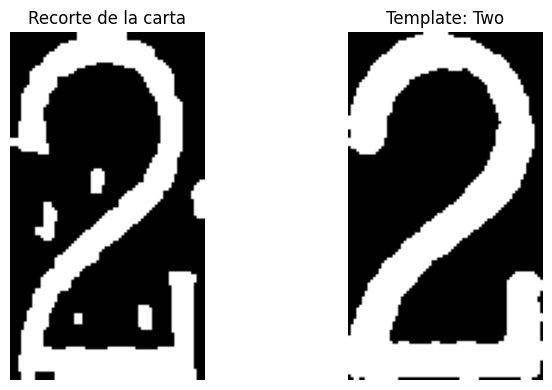

Two: score = 0.6977


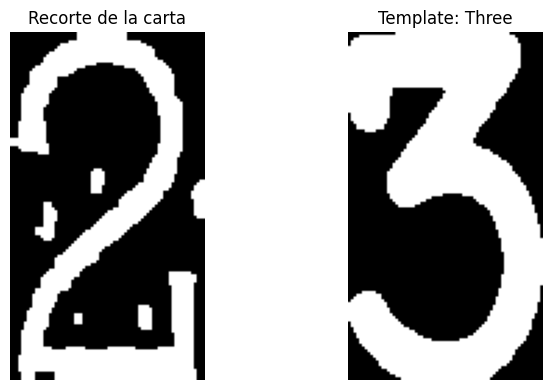

Three: score = 0.1602


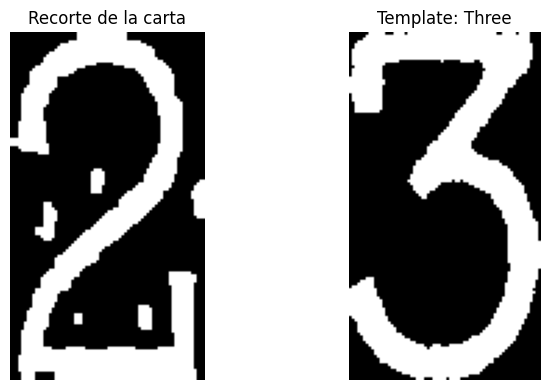

Three: score = 0.1726


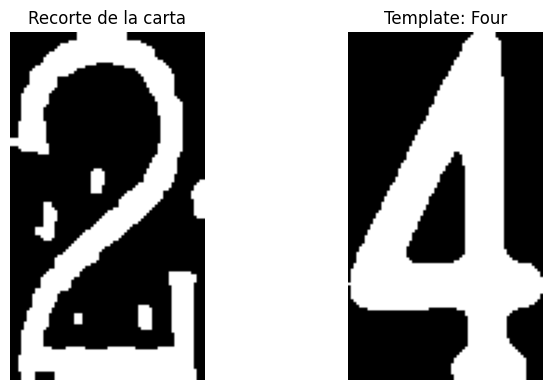

Four: score = -0.0494


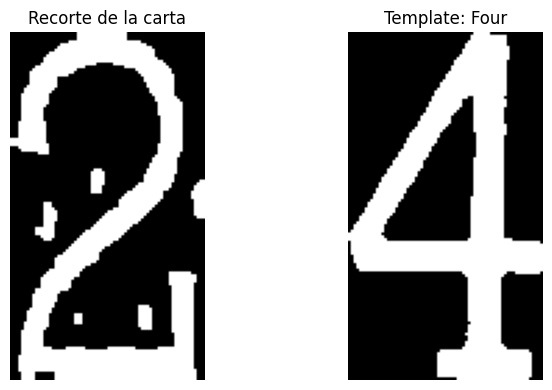

Four: score = 0.0069


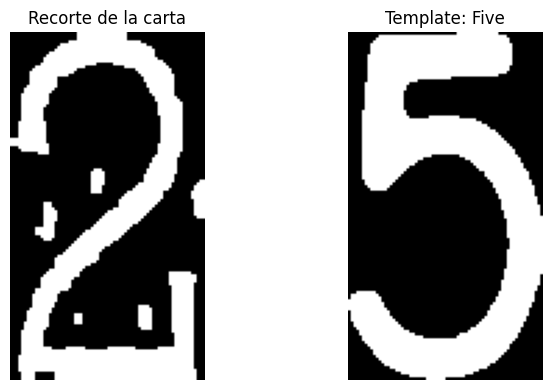

Five: score = 0.1791


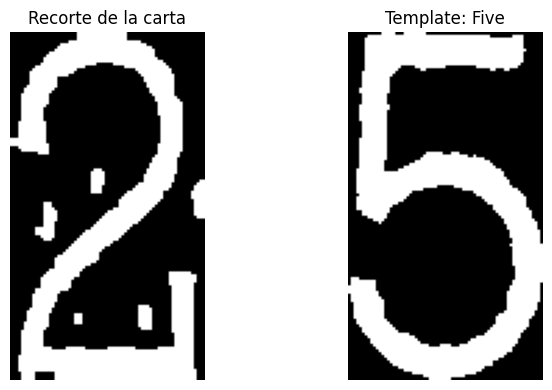

Five: score = 0.2222


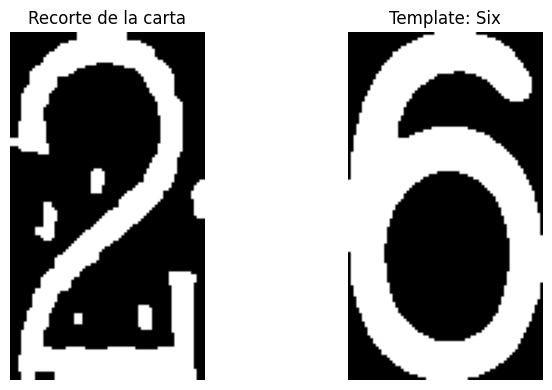

Six: score = 0.1456


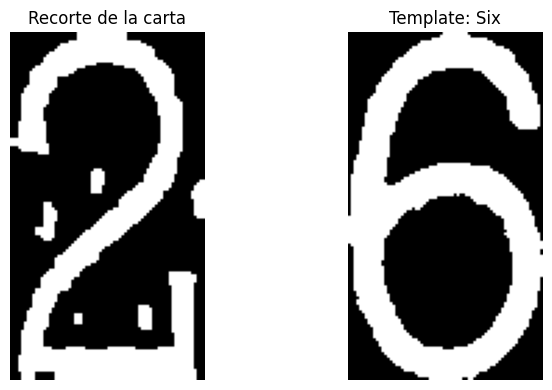

Six: score = 0.1904


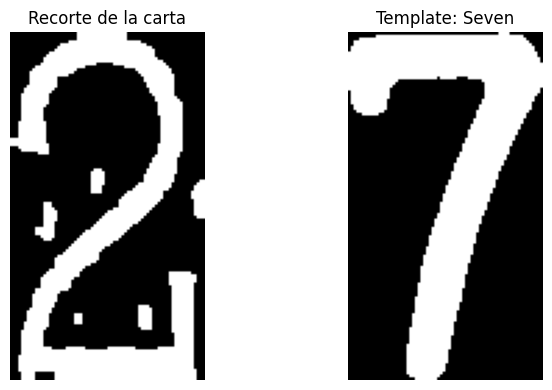

Seven: score = 0.1604


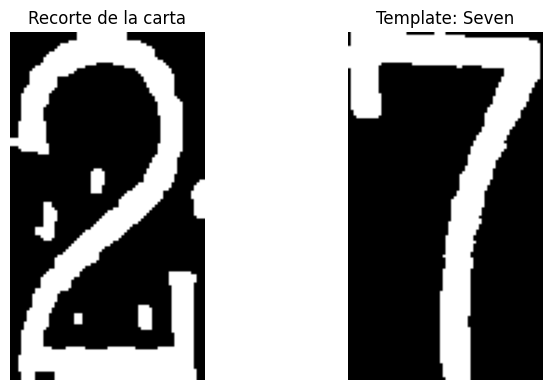

Seven: score = 0.1265


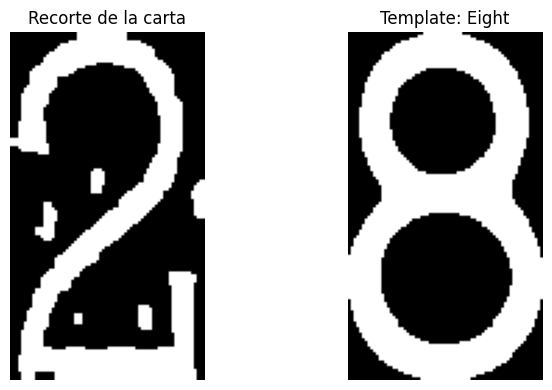

Eight: score = 0.3682


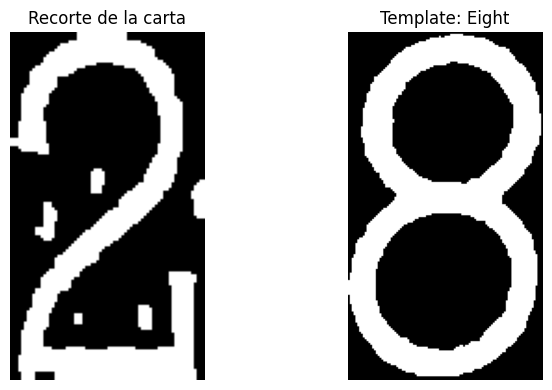

Eight: score = 0.2724


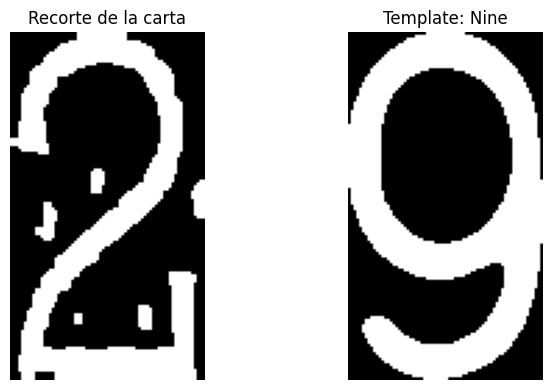

Nine: score = 0.2681


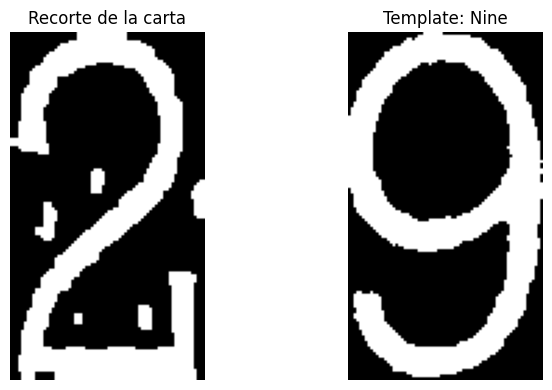

Nine: score = 0.3485


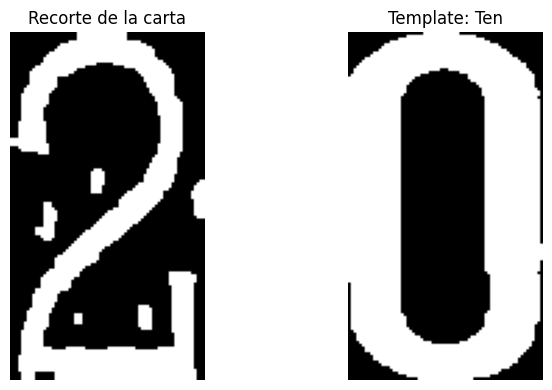

Ten: score = 0.2657


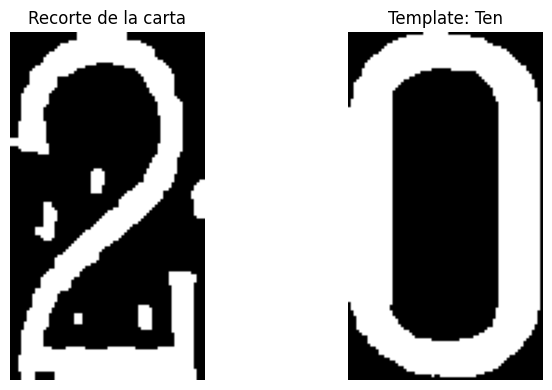

Ten: score = 0.2618


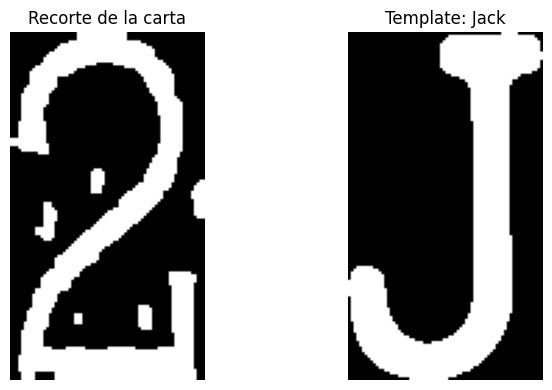

Jack: score = 0.1484


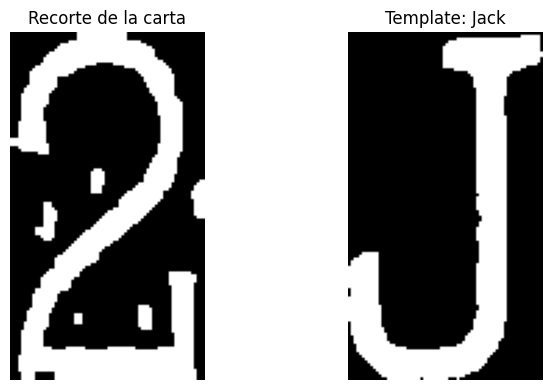

Jack: score = 0.1679


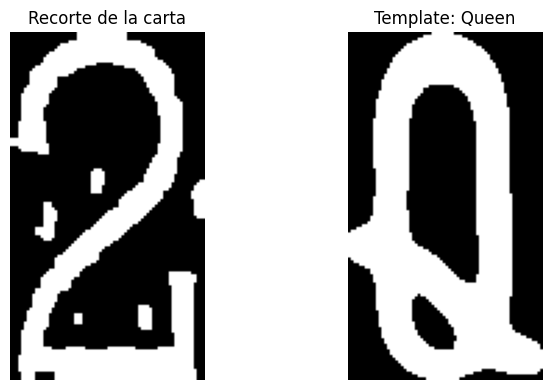

Queen: score = 0.1378


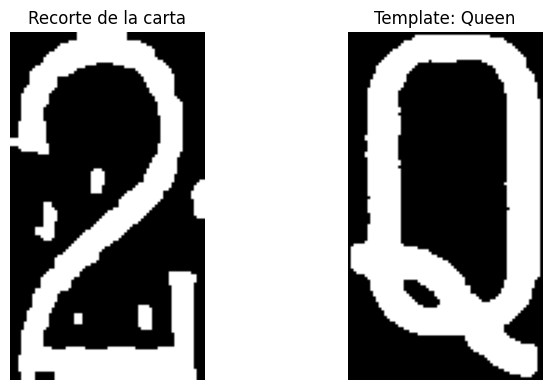

Queen: score = 0.0937


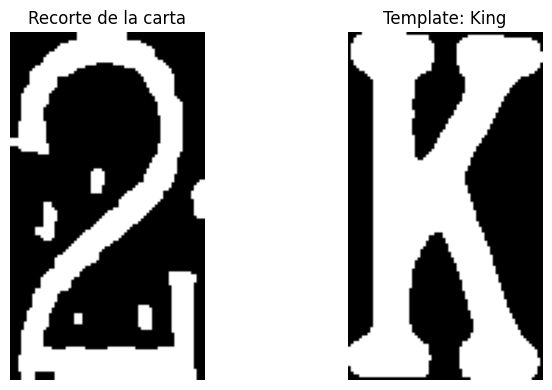

King: score = 0.1210


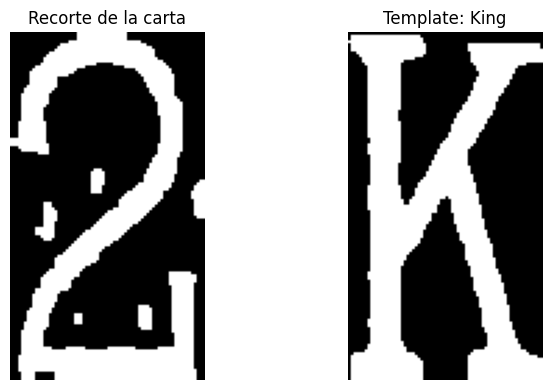

King: score = 0.1373


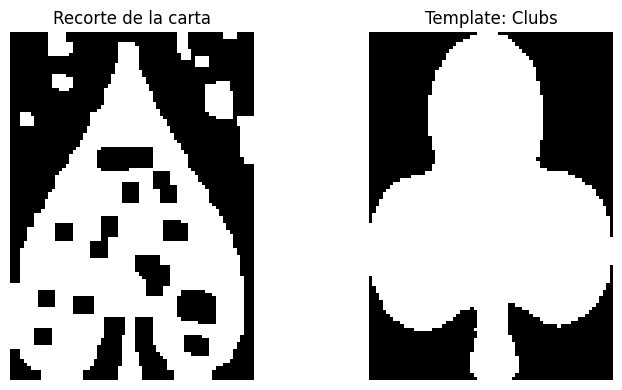

Clubs: score = 0.2889


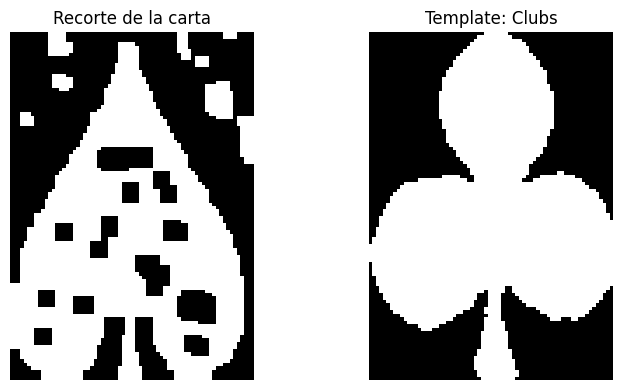

Clubs: score = 0.2734


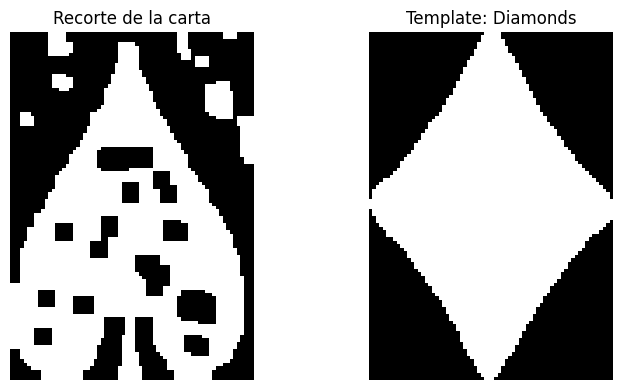

Diamonds: score = 0.2436


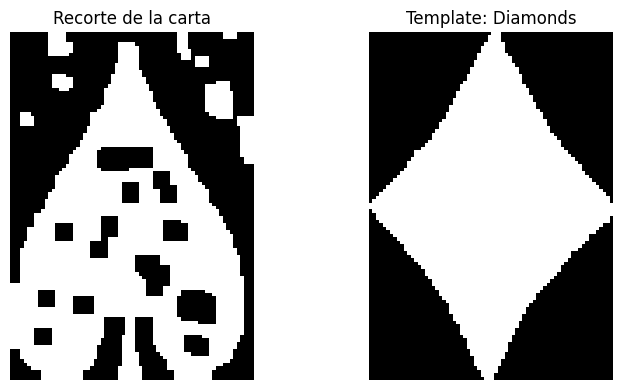

Diamonds: score = 0.2714


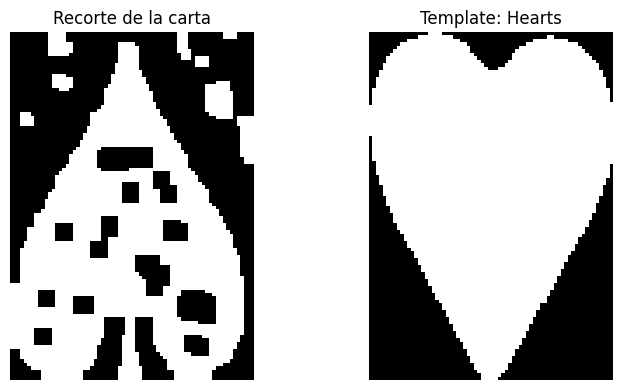

Hearts: score = -0.0168


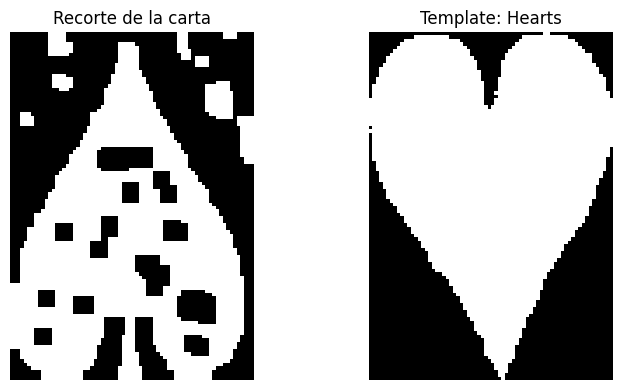

Hearts: score = -0.0694


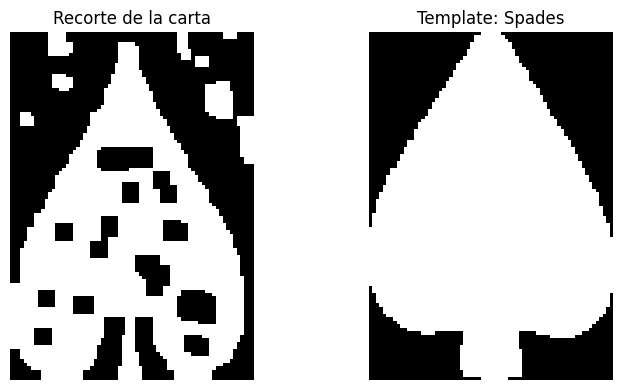

Spades: score = 0.2852


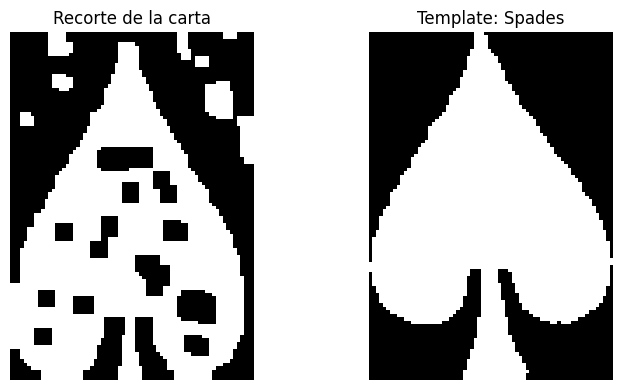

Spades: score = 0.3607
🃏 Card detected: Two of Spades


('Two', 'Spades')

In [12]:
main("Fotos/Imagenes/2S0.jpg", debug=True)

In [13]:
import os
import re
import sys

suits = {
    "Clubs": "C",
    "Diamonds": "D",
    "Hearts": "H",
    "Spades": "S"
}

numbers = {
    "Ace": "A",
    "Two": "2",
    "Three": "3",
    "Four": "4",
    "Five": "5",
    "Six": "6",
    "Seven": "7",
    "Eight": "8",
    "Nine": "9",
    "Ten": "10",
    "Jack": "J",
    "Queen": "Q",
    "King": "K"
}

def extraer_datos(nombre):
    match = re.match(r"(\w+)([A-Z])", nombre)
    if match:
        numero = match.group(1)
        letra = match.group(2)
        return numero, letra
    return None, None

succession = []

# Generar combinaciones: cada carta en 3 posiciones
for number_name, number_symbol in numbers.items():
    for suit_name, suit_symbol in suits.items():
        for i in range(2):  # 3 posiciones por carta
            filename = f"{number_symbol}{suit_symbol}{i}.jpg"
            ruta_completa = os.path.join("Fotos", "Imagenes", filename)
            if not os.path.exists(ruta_completa):
                print(f"⚠️ Archivo no encontrado: {ruta_completa}")
                continue
            print("Archivo:", filename)
            print("-" * 100)

            number, suit = main(ruta_completa)  # tu función real de predicción
            number_prediction, suit_prediction = extraer_datos(filename)
            
            if suit is None or number is None:
                print("❌ No se pudo predecir")
                succession.append(False)
            else:
                if suits[suit] == suit_prediction and numbers[number] == number_prediction:
                    print("✅ Acierto")
                    succession.append(True)
                else:
                    print("❌ Fallo")
                    succession.append(False)

            print("=" * 100)

# Calcular totales
total = len(succession)
aciertos = succession.count(True)
fallos = succession.count(False)

# Calcular porcentajes
porcentaje_aciertos = (aciertos / total) * 100
porcentaje_fallos = (fallos / total) * 100

print(f"\nResumen final:")
print(f"Aciertos: {porcentaje_aciertos:.2f}%")
print(f"Fallos: {porcentaje_fallos:.2f}%")


Archivo: AC0.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Buscando los contornos de cartas
Analizando las cartas
🃏 Card detected: Ace of Clubs
✅ Acierto
Archivo: AC1.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Buscando los contornos de cartas
Analizando las cartas
⚠️ Proporción de la carta fuera de rango. Saltando...
🃏 Card detected: Ace of Clubs
✅ Acierto
Archivo: AD0.jpg
----------------------------------------------------------------------------------------------------


C:\Users\migue\AppData\Local\Temp\ipykernel_30020\225734866.py:130: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


Detectando edges
Buscando los contornos de cartas
Analizando las cartas
🃏 Card detected: Ace of Diamonds
✅ Acierto
Archivo: AD1.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Buscando los contornos de cartas
Analizando las cartas
🃏 Card detected: Ace of Diamonds
✅ Acierto
Archivo: AH0.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Buscando los contornos de cartas
Analizando las cartas
🃏 Card detected: Three of Hearts
❌ Fallo
Archivo: AH1.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Buscando los contornos de cartas
Analizando las cartas
🃏 Card detected: Three of Spades
❌ Fallo
Archivo: AS0.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Buscando los contornos de cartas
Analizando las cartas


Detectando edges
Buscando los contornos de cartas
Analizando las cartas
🃏 Card detected: Four of Clubs
✅ Acierto
Archivo: 4D0.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Buscando los contornos de cartas
Analizando las cartas
🃏 Card detected: Two of Hearts
❌ Fallo
Archivo: 4D1.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Buscando los contornos de cartas
Analizando las cartas
⚠️ Proporción de la carta fuera de rango. Saltando...
🃏 Card detected: Queen of Diamonds
❌ Fallo
Archivo: 4H0.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Buscando los contornos de cartas
Analizando las cartas
🃏 Card detected: Four of Hearts
✅ Acierto
Archivo: 4H1.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Busc

Detectando edges
Buscando los contornos de cartas
Analizando las cartas
🃏 Card detected: Seven of Diamonds
✅ Acierto
Archivo: 7D1.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Buscando los contornos de cartas
Analizando las cartas
🃏 Card detected: Ace of Diamonds
❌ Fallo
Archivo: 7H0.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Buscando los contornos de cartas
Analizando las cartas
🃏 Card detected: Queen of Clubs
❌ Fallo
Archivo: 7H1.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Buscando los contornos de cartas
Analizando las cartas
⚠️ Proporción de la carta fuera de rango. Saltando...
⚠️ No se pudieron extraer las regiones del número y palo.
❌ No se pudo predecir
Archivo: 7S0.jpg
---------------------------------------------------------------------------------

Detectando edges
Buscando los contornos de cartas
Analizando las cartas
🃏 Card detected: Ten of Clubs
✅ Acierto
Archivo: 10D0.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Buscando los contornos de cartas
Analizando las cartas
🃏 Card detected: Ten of Diamonds
✅ Acierto
Archivo: 10D1.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Buscando los contornos de cartas
Analizando las cartas
🃏 Card detected: Seven of Hearts
❌ Fallo
Archivo: 10H0.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Buscando los contornos de cartas
Analizando las cartas
🃏 Card detected: Five of Spades
❌ Fallo
Archivo: 10H1.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Buscando los contornos de cartas
Analizando las cartas


Detectando edges
Buscando los contornos de cartas
Analizando las cartas
🃏 Card detected: Ace of Hearts
❌ Fallo
Archivo: KD0.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Buscando los contornos de cartas
Analizando las cartas
🃏 Card detected: King of Diamonds
✅ Acierto
Archivo: KD1.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Buscando los contornos de cartas
Analizando las cartas
🃏 Card detected: King of Diamonds
✅ Acierto
Archivo: KH0.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Buscando los contornos de cartas
Analizando las cartas
🃏 Card detected: King of Hearts
✅ Acierto
Archivo: KH1.jpg
----------------------------------------------------------------------------------------------------
Detectando edges
Buscando los contornos de cartas
Analizando las cartas